In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing necessary Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.metrics import BinaryAccuracy, Precision,Recall
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,InputLayer,BatchNormalization,Activation, Input,Dropout,GlobalAveragePooling2D,MaxPooling2D,Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy

import wandb
from wandb.keras import WandbCallback 

from tensorflow.keras.utils import plot_model
from IPython.display import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# DataSet Creation

In [3]:
train_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
validation_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

CLASS_NAMES = ['FAKE','REAL']

### Setting Our Configuration for the model

In [4]:
CONFIGURATION ={
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

#### Importing datasets and storing them in train and validation dataset

In [5]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    labels = 'inferred',
    label_mode = 'binary',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"] ),
    shuffle=True,
    seed=99,
)

Found 100000 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = validation_directory,
    labels = 'inferred',
    label_mode = 'binary',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"] ),
    shuffle=True,
    seed=99,
)

Found 20000 files belonging to 2 classes.


Checking if dataset has been prepared correctly

In [7]:
# Printing first element of first batch
for i in training_dataset.take(1):
    print(i)
    

(<tf.Tensor: shape=(32, 64, 64, 3), dtype=float32, numpy=
array([[[[195.    , 197.    , 184.    ],
         [199.5   , 201.5   , 188.5   ],
         [208.5   , 210.5   , 197.5   ],
         ...,
         [ 70.5   ,  71.5   ,  65.5   ],
         [ 81.5   ,  82.5   ,  76.5   ],
         [ 87.    ,  88.    ,  82.    ]],

        [[180.75  , 182.75  , 169.75  ],
         [187.125 , 189.125 , 176.125 ],
         [199.875 , 201.875 , 188.875 ],
         ...,
         [ 76.4375,  77.4375,  71.625 ],
         [ 85.8125,  86.8125,  80.875 ],
         [ 90.5   ,  91.5   ,  85.5   ]],

        [[152.25  , 154.25  , 141.25  ],
         [162.375 , 164.375 , 151.375 ],
         [182.625 , 184.625 , 171.625 ],
         ...,
         [ 88.3125,  89.3125,  83.875 ],
         [ 94.4375,  95.4375,  89.625 ],
         [ 97.5   ,  98.5   ,  92.5   ]],

        ...,

        [[ 88.    ,  95.    ,  88.    ],
         [ 89.625 ,  96.625 ,  89.625 ],
         [ 92.875 ,  99.875 ,  92.875 ],
         ...,
     

# Data Visualization

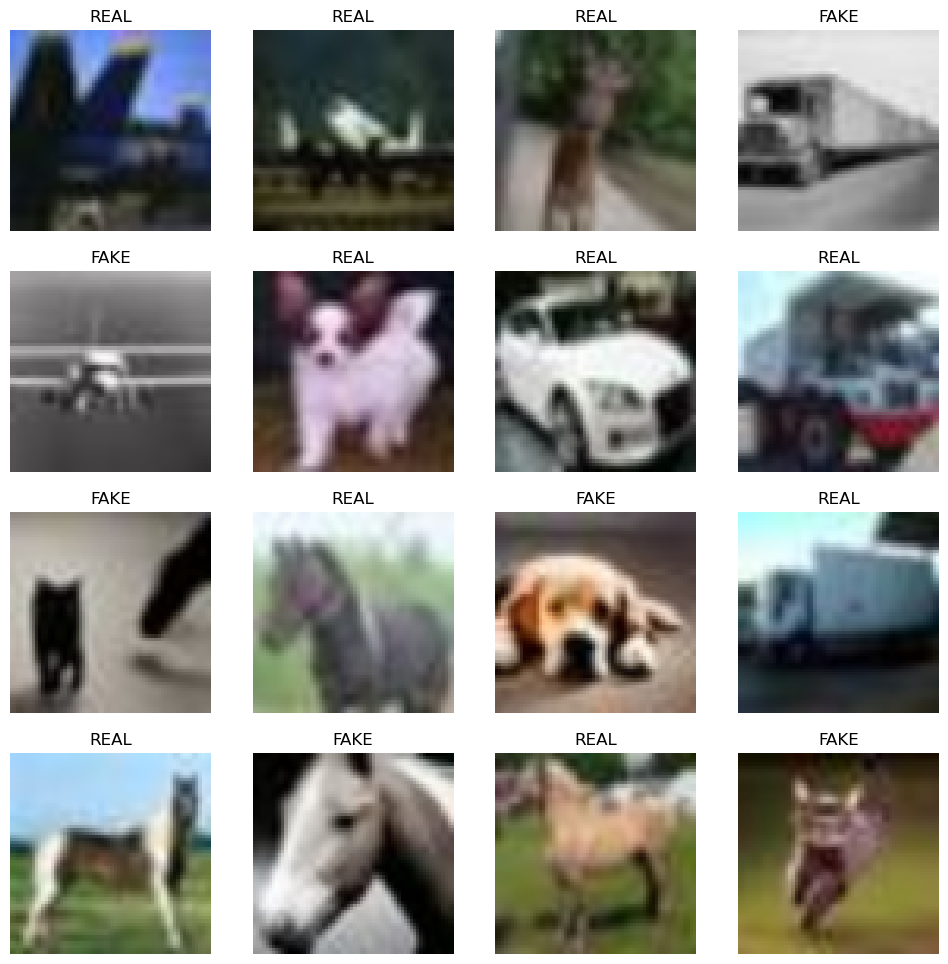

In [8]:
plt.figure(figsize = (12,12))
for image, label in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.)
        plt.title(CLASS_NAMES[int(label[i])])
        plt.axis('off')

# DataSet Preparation

In [9]:
training_dataset = (
    training_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
validation_dataset = (
    validation_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# Designing Callbacks for Model

In [12]:
# Customized Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch <= 10:
        return 0.001
    elif epoch<= 25:
        return 0.0001
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler,verbose=1)
    

In [13]:
# Reduce LR On no Improvement
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 1,
    verbose = 1,
    mode = 'min',
    min_delta = 0.000001,
    cooldown = 0,
    min_lr = 1e-15,
)

In [14]:
# Model Checkpointing
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/CNN_checkpoint',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    save_freq='epoch',
)

## Wandb
Using wandb to track performance of the model

In [16]:
!wandb login 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
wandb.init(project='Real-vs-Fake-Image-Classification',entity="technopath2003")

wandb: Currently logged in as: technopath2003. Use `wandb login --relogin` to force relogin


In [18]:
wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

In [19]:
CONFIGURATION = wandb.config

# Model Creation

## Model From Scratch

### Basic CNN Model

In [20]:
cnn_model = tf.keras.Sequential([
    InputLayer(input_shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    
    Conv2D(filters = CONFIGURATION['N_FILTERS'],kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],padding='valid',activation='relu',
           kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],strides = CONFIGURATION['N_STRIDES']*2),
    
    
    Conv2D(filters = CONFIGURATION['N_FILTERS']*2,kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],padding='valid',activation='relu',
           kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],strides = CONFIGURATION['N_STRIDES']*2),
    
    
    Conv2D(filters = CONFIGURATION['N_FILTERS']*3,kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],padding='valid',activation='relu',
           kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],strides = CONFIGURATION['N_STRIDES']*2),
    
    
    GlobalAveragePooling2D(),
    
    Dense(CONFIGURATION['N_DENSE_1'],activation='relu',kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_2'],activation='relu',kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    
    Dense(1,activation='sigmoid')
])

In [21]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 6)         168       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 12)        660       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 12)       48        
 hNormalization)                                                 
                                                        

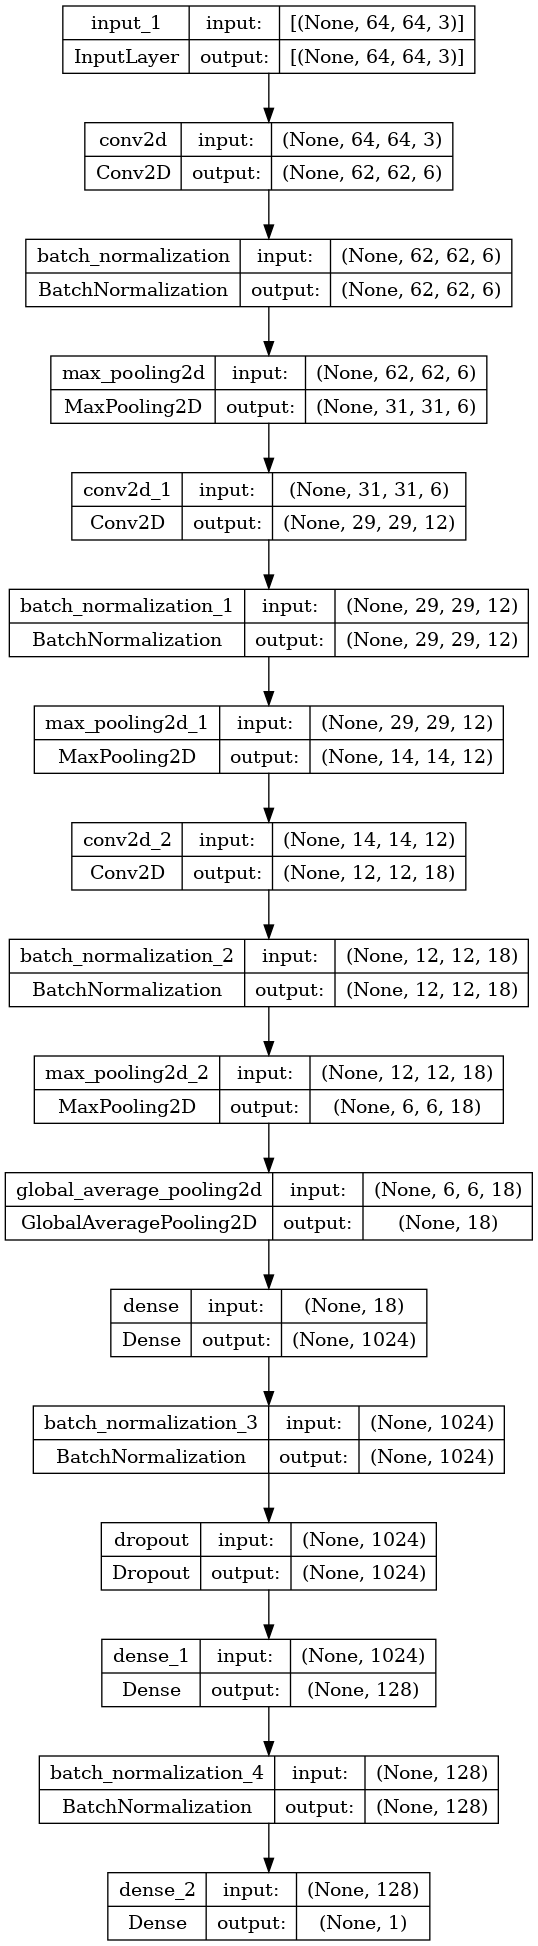

In [22]:
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True,show_layer_names=True)
Image(filename='cnn_model.png') 

In [23]:
metrics = [BinaryAccuracy(name='Accuracy'),Precision(name='Precision'),Recall(name='Recall')]

In [24]:
cnn_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

#### Model Training

In [25]:
wandb.run

cnn_history = cnn_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']
    , callbacks = [reduce_lr, model_checkpoint, WandbCallback()]
)

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.3400 - Accuracy: 0.8529 - Precision: 0.8540 - Recall: 0.8512
Epoch 1: val_loss improved from inf to 0.33748, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 861s 272ms/step - loss: 0.3400 - Accuracy: 0.8529 - Precision: 0.8541 - Recall: 0.8513 - val_loss: 0.3375 - val_Accuracy: 0.8536 - val_Precision: 0.8254 - val_Recall: 0.8970 - lr: 0.0010
Epoch 2/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.2707 - Accuracy: 0.8879 - Precision: 0.8898 - Recall: 0.8855
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_loss did not improve from 0.33748
3125/3125 [==============================] - 191s 61ms/step - loss: 0.2708 - Accuracy: 0.8879 - Precision: 0.8898 - Recall: 0.8854 - val_loss: 0.4198 - val_Accuracy: 0.8271 - val_Precision: 0.7655 - val_Recall: 0.9431 - lr: 0.0010
Epoch 3/20
3120/3125 [============================>.] - ETA: 0s - loss: 0.2276 - Accuracy: 0.9069 - Precision: 0.9093 - Recall: 0.9038
Epoch 3: val_loss improved from 0.33748 to 0.20713, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 189s 60ms/step - loss: 0.2275 - Accuracy: 0.9068 - Precision: 0.9093 - Recall: 0.9038 - val_loss: 0.2071 - val_Accuracy: 0.9178 - val_Precision: 0.9213 - val_Recall: 0.9137 - lr: 1.0000e-04
Epoch 4/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2211 - Accuracy: 0.9101 - Precision: 0.9123 - Recall: 0.9073
Epoch 4: val_loss improved from 0.20713 to 0.19801, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 73s 23ms/step - loss: 0.2211 - Accuracy: 0.9101 - Precision: 0.9124 - Recall: 0.9073 - val_loss: 0.1980 - val_Accuracy: 0.9198 - val_Precision: 0.9136 - val_Recall: 0.9274 - lr: 1.0000e-04
Epoch 5/20
3119/3125 [============================>.] - ETA: 0s - loss: 0.2171 - Accuracy: 0.9128 - Precision: 0.9151 - Recall: 0.9102
Epoch 5: val_loss improved from 0.19801 to 0.19232, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 74s 24ms/step - loss: 0.2172 - Accuracy: 0.9128 - Precision: 0.9150 - Recall: 0.9102 - val_loss: 0.1923 - val_Accuracy: 0.9230 - val_Precision: 0.9219 - val_Recall: 0.9242 - lr: 1.0000e-04
Epoch 6/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.2124 - Accuracy: 0.9154 - Precision: 0.9179 - Recall: 0.9125
Epoch 6: val_loss improved from 0.19232 to 0.18983, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.2123 - Accuracy: 0.9154 - Precision: 0.9178 - Recall: 0.9125 - val_loss: 0.1898 - val_Accuracy: 0.9241 - val_Precision: 0.9213 - val_Recall: 0.9275 - lr: 1.0000e-04
Epoch 7/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2100 - Accuracy: 0.9155 - Precision: 0.9183 - Recall: 0.9121
Epoch 7: val_loss improved from 0.18983 to 0.18435, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 73s 23ms/step - loss: 0.2100 - Accuracy: 0.9155 - Precision: 0.9183 - Recall: 0.9120 - val_loss: 0.1844 - val_Accuracy: 0.9270 - val_Precision: 0.9204 - val_Recall: 0.9349 - lr: 1.0000e-04
Epoch 8/20
3119/3125 [============================>.] - ETA: 0s - loss: 0.2071 - Accuracy: 0.9164 - Precision: 0.9185 - Recall: 0.9139
Epoch 8: val_loss improved from 0.18435 to 0.18161, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 71s 23ms/step - loss: 0.2071 - Accuracy: 0.9164 - Precision: 0.9185 - Recall: 0.9140 - val_loss: 0.1816 - val_Accuracy: 0.9263 - val_Precision: 0.9295 - val_Recall: 0.9227 - lr: 1.0000e-04
Epoch 9/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2034 - Accuracy: 0.9188 - Precision: 0.9220 - Recall: 0.9150
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 9: val_loss did not improve from 0.18161
3125/3125 [==============================] - 70s 22ms/step - loss: 0.2034 - Accuracy: 0.9188 - Precision: 0.9220 - Recall: 0.9150 - val_loss: 0.1833 - val_Accuracy: 0.9270 - val_Precision: 0.9239 - val_Recall: 0.9308 - lr: 1.0000e-04
Epoch 10/20
3125/3125 [==============================] - ETA: 0s - loss: 0.2003 - Accuracy: 0.9201 - Precision: 0.9225 - Recall: 0.9173
Epoch 10: val_loss improved from 0.18161 to 0.17812, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.2003 - Accuracy: 0.9201 - Precision: 0.9225 - Recall: 0.9173 - val_loss: 0.1781 - val_Accuracy: 0.9288 - val_Precision: 0.9317 - val_Recall: 0.9254 - lr: 1.0000e-05
Epoch 11/20
3121/3125 [============================>.] - ETA: 0s - loss: 0.1961 - Accuracy: 0.9218 - Precision: 0.9244 - Recall: 0.9187
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 12: val_loss did not improve from 0.17776
3125/3125 [==============================] - 70s 22ms/step - loss: 0.1961 - Accuracy: 0.9218 - Precision: 0.9243 - Recall: 0.9187 - val_loss: 0.1782 - val_Accuracy: 0.9285 - val_Precision: 0.9300 - val_Recall: 0.9267 - lr: 1.0000e-05
Epoch 13/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.1959 - Accuracy: 0.9211 - Precision: 0.9235 - Recall: 0.9182
Epoch 13: val_loss improved from 0.17776 to 0.17758, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.1960 - Accuracy: 0.9211 - Precision: 0.9235 - Recall: 0.9182 - val_loss: 0.1776 - val_Accuracy: 0.9290 - val_Precision: 0.9319 - val_Recall: 0.9257 - lr: 1.0000e-06
Epoch 14/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1967 - Accuracy: 0.9213 - Precision: 0.9234 - Recall: 0.9188
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 14: val_loss did not improve from 0.17758
3125/3125 [==============================] - 73s 23ms/step - loss: 0.1967 - Accuracy: 0.9213 - Precision: 0.9234 - Recall: 0.9188 - val_loss: 0.1776 - val_Accuracy: 0.9290 - val_Precision: 0.9321 - val_Recall: 0.9254 - lr: 1.0000e-06
Epoch 15/20
3120/3125 [============================>.] - ETA: 0s - loss: 0.1974 - Accuracy: 0.9206 - Precision: 0.9227 - Recall: 0.9182
Epoch 15: val_loss improved from 0.17758 to 0.17756, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.1974 - Accuracy: 0.9206 - Precision: 0.9226 - Recall: 0.9182 - val_loss: 0.1776 - val_Accuracy: 0.9294 - val_Precision: 0.9321 - val_Recall: 0.9262 - lr: 1.0000e-07
Epoch 16/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.1965 - Accuracy: 0.9214 - Precision: 0.9232 - Recall: 0.9192
Epoch 16: val_loss improved from 0.17756 to 0.17753, saving model to /kaggle/working/CNN_checkpoint


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.1965 - Accuracy: 0.9214 - Precision: 0.9232 - Recall: 0.9192 - val_loss: 0.1775 - val_Accuracy: 0.9293 - val_Precision: 0.9324 - val_Recall: 0.9257 - lr: 1.0000e-07
Epoch 17/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.1979 - Accuracy: 0.9212 - Precision: 0.9230 - Recall: 0.9192
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 17: val_loss did not improve from 0.17753
3125/3125 [==============================] - 69s 22ms/step - loss: 0.1979 - Accuracy: 0.9212 - Precision: 0.9230 - Recall: 0.9192 - val_loss: 0.1775 - val_Accuracy: 0.9294 - val_Precision: 0.9318 - val_Recall: 0.9267 - lr: 1.0000e-07
Epoch 18/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.1959 - Accuracy: 0.9217 - Precision: 0.9233 - Recall: 0.9198
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 18: val_loss did not improve from 0.17753
3125/312

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_045635-ac1sn35d/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 72s 23ms/step - loss: 0.1971 - Accuracy: 0.9207 - Precision: 0.9225 - Recall: 0.9185 - val_loss: 0.1775 - val_Accuracy: 0.9292 - val_Precision: 0.9321 - val_Recall: 0.9259 - lr: 1.0000e-09
Epoch 20/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.1970 - Accuracy: 0.9212 - Precision: 0.9233 - Recall: 0.9186
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 20: val_loss did not improve from 0.17747
3125/3125 [==============================] - 69s 22ms/step - loss: 0.1970 - Accuracy: 0.9212 - Precision: 0.9233 - Recall: 0.9186 - val_loss: 0.1776 - val_Accuracy: 0.9294 - val_Precision: 0.9316 - val_Recall: 0.9268 - lr: 1.0000e-09


Accuracy,▁▅▆▇▇▇▇▇████████████
Precision,▁▅▇▇▇▇▇▇████████████
Recall,▁▄▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,██▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_Accuracy,▃▁▇▇████████████████
val_Precision,▄▁█▇██▇█████████████
val_Recall,▁█▄▆▅▆▇▅▆▅▅▆▅▅▅▅▆▅▅▆
val_loss,▆█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.92116


#### CNN Model Evaluation

In [26]:
cnn_model.load_weights('CNN_checkpoint')

In [27]:
cnn_model.evaluate(validation_dataset)

625/625 [==============================] - 11s 18ms/step - loss: 0.1775 - Accuracy: 0.9292 - Precision: 0.9321 - Recall: 0.9259


[0.17746561765670776,
 0.9291999936103821,
 0.9320515394210815,
 0.9258999824523926]

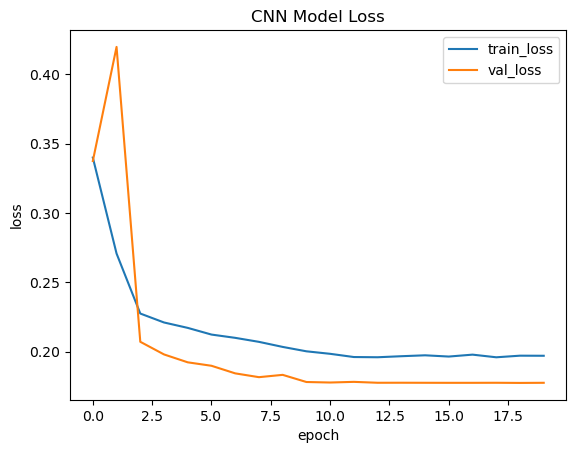

In [28]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

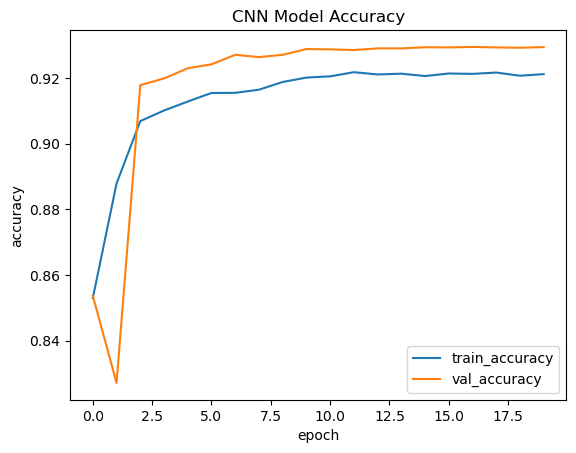

In [29]:
plt.plot(cnn_history.history['Accuracy'])
plt.plot(cnn_history.history['val_Accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

### ResNet_34

In [30]:
wandb.init(project='Real-vs-Fake-Image-Classification',entity="technopath2003")

wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

CONFIGURATION = wandb.config

In [31]:
# Model Checkpointing
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/ResNet34_checkpoint',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    save_freq='epoch',
)

In [32]:
class CustomConv2D(Layer):
    def __init__(self,n_filters,kernel_size,n_strides,padding = 'valid'):
        super(CustomConv2D,self).__init__(name = 'custom_conv2d')
        
        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = n_strides,
            padding = padding)
        
        self.batch_norm = BatchNormalization()
        
    def call(self,x,training = True):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        
        return x

In [33]:
class ResidualBlock(Layer):
    def __init__(self,n_channels,n_strides=1):
        super(ResidualBlock,self).__init__(name = 'res_block')
        
        self.dotted = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels,3,n_strides,padding = 'same')
        self.custom_conv_2 = CustomConv2D(n_channels,3,1,padding = 'same')
        
        self.activation = Activation('relu')
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels,1,n_strides)
        
    def call(self, input,training):
        x = self.custom_conv_1(input,training)
        x = self.custom_conv_2(x,training)
        
        if self.dotted:
            x_add = self.custom_conv_3(input,training)
            x_add = Add()([x,x_add])
        else :
            x_add = Add()([x,input])
        
        return self.activation(x_add)

In [34]:
class ResNet34(Model):
    def __init__(self,):
        super(ResNet34,self).__init__(name = 'resnet_34')
        
        self.conv_1 = CustomConv2D(64,7,2,padding = 'same')  # 7 kernel, 2 stride
        self.max_pool = MaxPooling2D(3,2) # 3x3 , 2 stride
        
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128,2) 
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256,2) 
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512,2) 
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        
        self.global_pool = GlobalAveragePooling2D()
        
        self.fc_3 = Dense(1,activation = 'sigmoid')
        
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.max_pool(x)
        
        x = self.conv_2_1(x,training)
        x = self.conv_2_2(x,training)
        x = self.conv_2_3(x,training)
        
        x = self.conv_3_1(x,training)
        x = self.conv_3_2(x,training)
        x = self.conv_3_3(x,training)
        x = self.conv_3_4(x,training)
        
        x = self.conv_4_1(x,training)
        x = self.conv_4_2(x,training)
        x = self.conv_4_3(x,training)
        x = self.conv_4_4(x,training)
        x = self.conv_4_5(x,training)
        x = self.conv_4_6(x,training)
        
        x = self.conv_5_1(x,training)
        x = self.conv_5_2(x,training)
        x = self.conv_5_3(x,training)
        
        x = self.global_pool(x)
        
        return self.fc_3(x)

In [35]:
resnet34_model = ResNet34()
resnet34_model(tf.zeros([1,256,256,3]), training = False)
resnet34_model.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

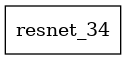

In [36]:
plot_model(resnet34_model, to_file='resnet34_model.png', show_shapes=True,show_layer_names=True)
Image(filename='resnet34_model.png') 

In [37]:
resnet34_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

#### Model Training

In [38]:
wandb.run

resnet34_model_history = resnet34_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']
    , callbacks = [reduce_lr, model_checkpoint, WandbCallback()]
)

wandb.finish()

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.3531 - Accuracy: 0.8638 - Precision: 0.8631 - Recall: 0.8649
Epoch 1: val_loss improved from inf to 0.37326, saving model to /kaggle/working/ResNet34_checkpoint


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_054155-6ad12dtx/files/model-best)... Done. 1.0s


3125/3125 [==============================] - 192s 53ms/step - loss: 0.3531 - Accuracy: 0.8638 - Precision: 0.8631 - Recall: 0.8649 - val_loss: 0.3733 - val_Accuracy: 0.8348 - val_Precision: 0.8336 - val_Recall: 0.8366 - lr: 0.0010
Epoch 2/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2567 - Accuracy: 0.8977 - Precision: 0.8976 - Recall: 0.8980
Epoch 2: val_loss improved from 0.37326 to 0.23138, saving model to /kaggle/working/ResNet34_checkpoint


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_054155-6ad12dtx/files/model-best)... Done. 0.9s


3125/3125 [==============================] - 154s 49ms/step - loss: 0.2567 - Accuracy: 0.8977 - Precision: 0.8975 - Recall: 0.8980 - val_loss: 0.2314 - val_Accuracy: 0.9043 - val_Precision: 0.8977 - val_Recall: 0.9125 - lr: 0.0010
Epoch 3/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2158 - Accuracy: 0.9147 - Precision: 0.9157 - Recall: 0.9136
Epoch 3: val_loss improved from 0.23138 to 0.19345, saving model to /kaggle/working/ResNet34_checkpoint


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230712_054155-6ad12dtx/files/model-best)... Done. 0.9s


3125/3125 [==============================] - 154s 49ms/step - loss: 0.2158 - Accuracy: 0.9147 - Precision: 0.9156 - Recall: 0.9136 - val_loss: 0.1934 - val_Accuracy: 0.9247 - val_Precision: 0.9108 - val_Recall: 0.9417 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1904 - Accuracy: 0.9262 - Precision: 0.9252 - Recall: 0.9274
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 4: val_loss did not improve from 0.19345
3125/3125 [==============================] - 134s 43ms/step - loss: 0.1904 - Accuracy: 0.9262 - Precision: 0.9252 - Recall: 0.9274 - val_loss: 0.4948 - val_Accuracy: 0.8305 - val_Precision: 0.9860 - val_Recall: 0.6705 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.1281 - Accuracy: 0.9515 - Precision: 0.9505 - Recall: 0.9527
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 5: val_loss did not improve from 0.19345
3125/3125 [=======

Accuracy,▁▃▅▅▇███████████████
Precision,▁▃▅▅▇███████████████
Recall,▁▃▄▅▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Accuracy,▁▅▇▁▇███████████████
val_Precision,▁▄▅█▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_Recall,▅▇▇▁████████████████
val_loss,▁▁▁▁▅▇▆▇▆▇█▇█▇█▆█▇▇▇
Accuracy,0.96103


#### ResNet_34 Model Evaluation

In [39]:
resnet34_model.load_weights('ResNet34_checkpoint')

In [40]:
resnet34_model.evaluate(validation_dataset)

625/625 [==============================] - 13s 21ms/step - loss: 0.1934 - Accuracy: 0.9247 - Precision: 0.9108 - Recall: 0.9417


[0.1934460997581482,
 0.9247499704360962,
 0.9108231067657471,
 0.9416999816894531]

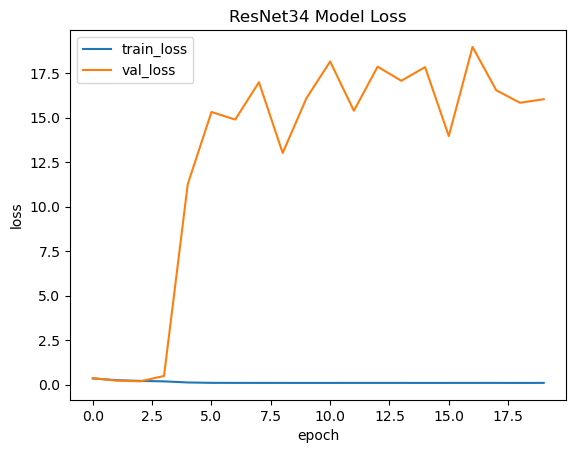

In [41]:
plt.plot(resnet34_model_history.history['loss'])
plt.plot(resnet34_model_history.history['val_loss'])
plt.title('ResNet34 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

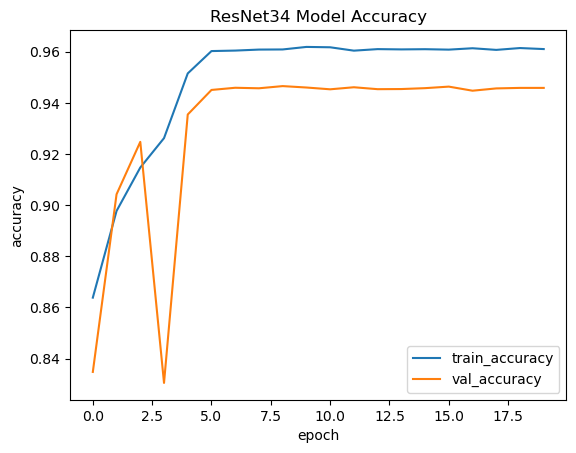

In [43]:
plt.plot(resnet34_model_history.history['Accuracy'])
plt.plot(resnet34_model_history.history['val_Accuracy'])
plt.title('ResNet34 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

## Using Pretrained Models

### EfficientNetB4

Model has some issues with checkpoint and model_save_weights type of callbacks,
so inorder for them to work you have to downgrade tensorflow with
**!pip install tensorflow==2.9.1**

In [44]:
wandb.init(project='Real-vs-Fake-Image-Classification',entity="technopath2003")

wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 2048,
    "N_DENSE_2": 1024,
    "N_DENSE_3": 256,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

CONFIGURATION = wandb.config

In [46]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
)

71686520/71686520 [==============================] - 0s 0us/step


In [47]:
backbone.trainable = False

In [54]:
efficientnet_b4_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    
    GlobalAveragePooling2D(),
    
    Dense(CONFIGURATION['N_DENSE_1'],activation ='relu'),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_2'],activation ='relu'),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_3'],activation ='relu'),
    BatchNormalization(),
    
    Dense(1,activation = 'sigmoid')
])

efficientnet_b4_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 2, 2, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2048)              3672064   
                                                                 
 batch_normalization_44 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)             

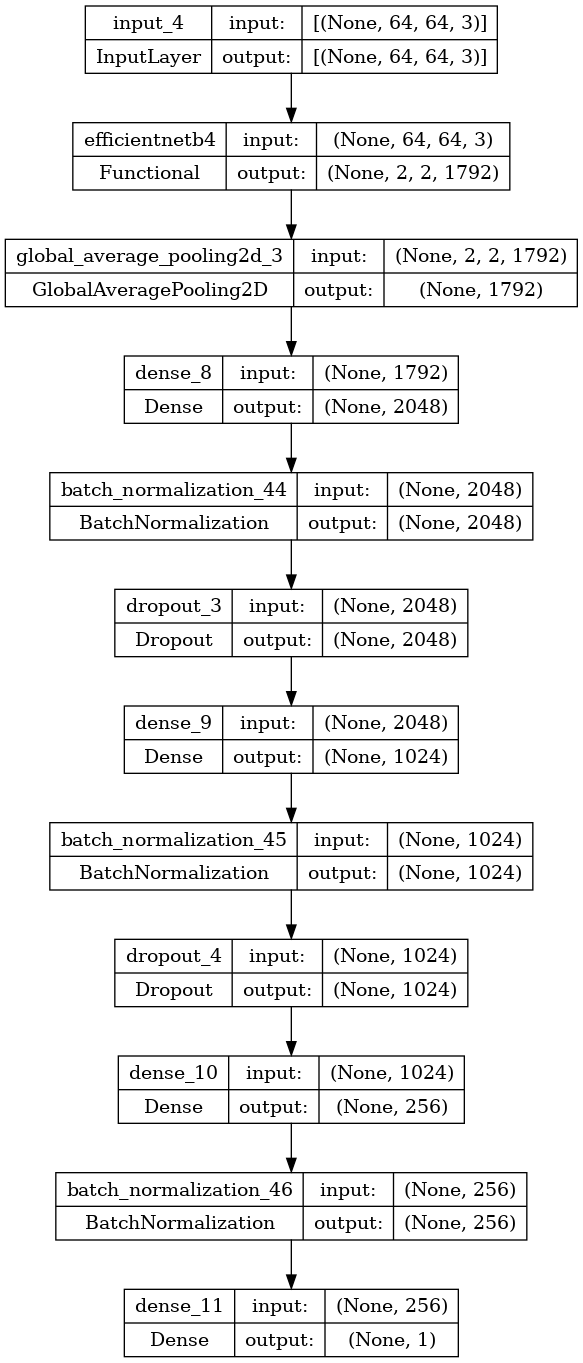

In [55]:
plot_model(efficientnet_b4_model, to_file='efficientnet_b4_model.png', show_shapes=True,show_layer_names=True)
Image(filename='efficientnet_b4_model.png') 

In [56]:
efficientnet_b4_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

In [57]:
wandb.run

efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']-5
    , callbacks = [reduce_lr, WandbCallback(save_model=(False))]
)

Epoch 1/15


2023-07-12 07:08:44.909349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3125/3125 [==============================] - 161s 45ms/step - loss: 0.3995 - Accuracy: 0.8233 - Precision: 0.8246 - Recall: 0.8214 - val_loss: 0.3120 - val_Accuracy: 0.8622 - val_Precision: 0.8651 - val_Recall: 0.8583 - lr: 0.0010
Epoch 2/15
3125/3125 [==============================] - 108s 35ms/step - loss: 0.3479 - Accuracy: 0.8484 - Precision: 0.8491 - Recall: 0.8472 - val_loss: 0.2986 - val_Accuracy: 0.8716 - val_Precision: 0.8669 - val_Recall: 0.8780 - lr: 0.0010
Epoch 3/15
3124/3125 [============================>.] - ETA: 0s - loss: 0.3234 - Accuracy: 0.8607 - Precision: 0.8613 - Recall: 0.8599
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3125/3125 [==============================] - 108s 34ms/step - loss: 0.3234 - Accuracy: 0.8607 - Precision: 0.8613 - Recall: 0.8599 - val_loss: 0.3070 - val_Accuracy: 0.8702 - val_Precision: 0.9091 - val_Recall: 0.8225 - lr: 0.0010
Epoch 4/15
3125/3125 [==============================] - 106s 34ms/step - loss: 0.282

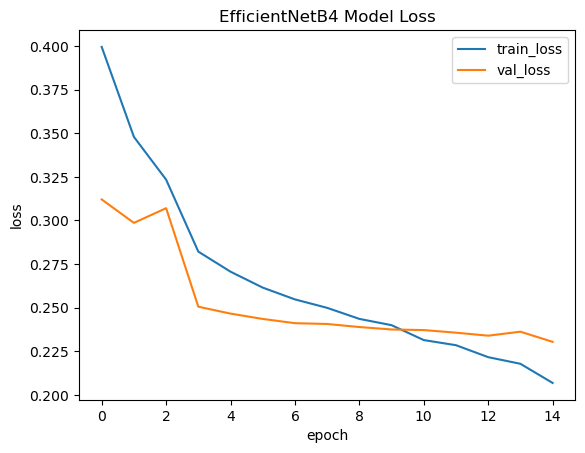

In [64]:
plt.plot(efficientnet_b4_history.history['loss'])
plt.plot(efficientnet_b4_history.history['val_loss'])
plt.title('EfficientNetB4 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

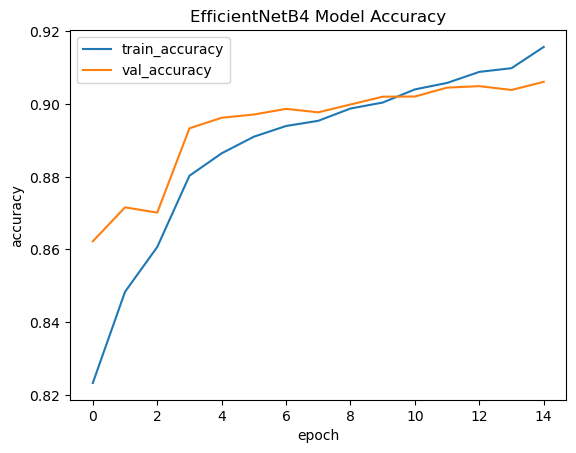

In [65]:
plt.plot(efficientnet_b4_history.history['Accuracy'])
plt.plot(efficientnet_b4_history.history['val_Accuracy'])
plt.title('EfficientNetB4 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

#### EfficientNetB4 Model Evaluation before Finetuning

Training it for more epochs as accuracy is still increasing

In [60]:
efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']
    , callbacks = [reduce_lr, WandbCallback(save_model=(False))]
)

Epoch 1/20
3125/3125 [==============================] - 109s 35ms/step - loss: 0.2041 - Accuracy: 0.9172 - Precision: 0.9165 - Recall: 0.9180 - val_loss: 0.2311 - val_Accuracy: 0.9068 - val_Precision: 0.9077 - val_Recall: 0.9057 - lr: 1.0000e-05
Epoch 2/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.2013 - Accuracy: 0.9198 - Precision: 0.9192 - Recall: 0.9204
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
3125/3125 [==============================] - 104s 33ms/step - loss: 0.2013 - Accuracy: 0.9198 - Precision: 0.9192 - Recall: 0.9204 - val_loss: 0.2314 - val_Accuracy: 0.9079 - val_Precision: 0.9096 - val_Recall: 0.9057 - lr: 1.0000e-05
Epoch 3/20
3125/3125 [==============================] - 107s 34ms/step - loss: 0.1998 - Accuracy: 0.9191 - Precision: 0.9178 - Recall: 0.9206 - val_loss: 0.2307 - val_Accuracy: 0.9074 - val_Precision: 0.9098 - val_Recall: 0.9045 - lr: 1.0000e-06
Epoch 4/20
3125/3125 [==============================] - ETA: 

KeyboardInterrupt: 

#### Evaluation before FineTuning

In [61]:
efficientnet_b4_model.evaluate(validation_dataset)

625/625 [==============================] - 20s 32ms/step - loss: 0.2311 - Accuracy: 0.9075 - Precision: 0.9097 - Recall: 0.9047


[0.23109914362430573,
 0.9074500203132629,
 0.9097033739089966,
 0.904699981212616]

#### FineTuning the model

By mistake due to an error I think I lost the pretrained model which had its output layers trained so instead I had to start training the model with all its layers set to trainable=True from start instead of Finetuning as I had used a lot of GPU Time

You can instead remember to downgrade Tensorflow before using this pretrained model

In [66]:
backbone.trainable = True

In [68]:
efficientnet_b4_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 2, 2, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2048)              3672064   
                                                                 
 batch_normalization_44 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)             

In [73]:
efficientnet_b4_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/1000),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

In [75]:
efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']*2
    , callbacks = [reduce_lr,WandbCallback(save_model=(False))]
)

wandb.finish()

Epoch 1/40
3125/3125 [==============================] - 322s 103ms/step - loss: 0.5145 - Accuracy: 0.8047 - Precision: 0.8048 - Recall: 0.8046 - val_loss: 0.4547 - val_Accuracy: 0.8124 - val_Precision: 0.8072 - val_Recall: 0.8208 - lr: 1.0000e-06
Epoch 2/40
3125/3125 [==============================] - 333s 106ms/step - loss: 0.4391 - Accuracy: 0.8226 - Precision: 0.8232 - Recall: 0.8217 - val_loss: 0.3983 - val_Accuracy: 0.8325 - val_Precision: 0.8302 - val_Recall: 0.8361 - lr: 1.0000e-06
Epoch 3/40
3125/3125 [==============================] - 329s 105ms/step - loss: 0.3887 - Accuracy: 0.8404 - Precision: 0.8415 - Recall: 0.8386 - val_loss: 0.3584 - val_Accuracy: 0.8486 - val_Precision: 0.8443 - val_Recall: 0.8549 - lr: 1.0000e-06
Epoch 4/40
3125/3125 [==============================] - 326s 104ms/step - loss: 0.3584 - Accuracy: 0.8522 - Precision: 0.8524 - Recall: 0.8518 - val_loss: 0.3283 - val_Accuracy: 0.8615 - val_Precision: 0.8588 - val_Recall: 0.8653 - lr: 1.0000e-06
Epoch 5/40
3

Accuracy,▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████████
Precision,▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████████
Recall,▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████
epoch,▁▁▁▂▂▂▂▃▃▃▁▁▂▂▂▂▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,███▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Accuracy,▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▁▄▄▅▆▆▆▇▇▇▇▇▇▇██████████
val_Precision,▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▁▄▄▅▆▆▆▇▇▇▇▇▇▇██████████
val_Recall,▁▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████████
val_loss,▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.95225


#### EfficientNetB4 Model Evaluation after Finetuning

In [76]:
efficientnet_b4_model.evaluate(validation_dataset)

625/625 [==============================] - 19s 31ms/step - loss: 0.1140 - Accuracy: 0.9578 - Precision: 0.9583 - Recall: 0.9572


[0.1139906719326973,
 0.9577500224113464,
 0.9582540988922119,
 0.9571999907493591]

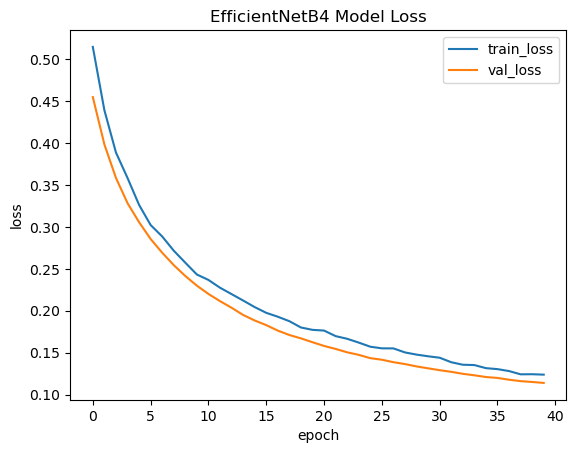

In [77]:
plt.plot(efficientnet_b4_history.history['loss'])
plt.plot(efficientnet_b4_history.history['val_loss'])
plt.title('EfficientNetB4 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

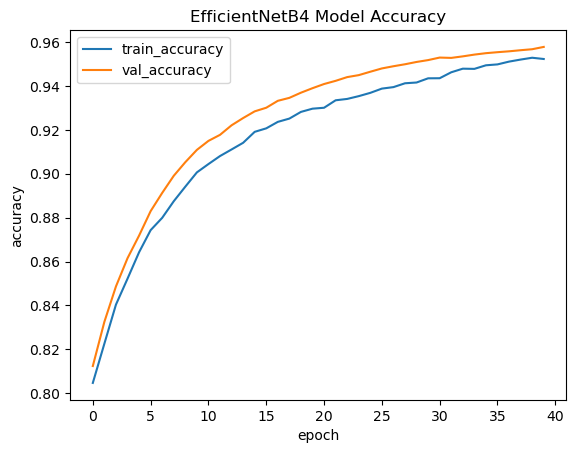

In [79]:
plt.plot(efficientnet_b4_history.history['Accuracy'])
plt.plot(efficientnet_b4_history.history['val_Accuracy'])
plt.title('EfficientNetB4 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Conclusion

Finetuning an EfficientNetB4 gave the best results and could give even more better results if it is run for more Epochs and with a lower Learning-Rate.